In [1]:
import librosa
import os # библиотека для работы с файлами
import matplotlib.pyplot as plt
import librosa.display as ld
import numpy as np
import pandas as pd
import random

## Предобработка всех файлов директории, создание датафрейма

### Извлечение характеристик из файлов

In [10]:
n_fft = 8195
sr = 22050
hop_length = n_fft // 2

def spectrum_feature(signal):
    ft = np.abs(librosa.stft(signal[:n_fft], n_fft=n_fft, hop_length=hop_length))
    mean_ft = np.mean(ft, axis=1)  # Усредняем по всем каналам

    return np.mean(mean_ft), np.var(mean_ft)

def db_spectrum_feature(signal):
    X = librosa.stft(signal)
    s = librosa.amplitude_to_db(abs(X))

    return np.mean(s), np.var(s)

def melspectrum_feature(signal):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc = 40, hop_length=512)

    return np.mean(mfccs), np.var(mfccs)

def db_melspectrum_feature(signal):
    melspectrum = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=512, n_mels=40)
    melspectrum_db = librosa.power_to_db(melspectrum, ref=np.max)  # Преобразуем в децибелы

    return np.mean(melspectrum_db), np.var(melspectrum_db)

def spectral_cent_feature(signal):
    cent = librosa.feature.spectral_centroid(y=signal, sr=sr)

    return np.mean(cent), np.var(cent)

def spectral_rolloff_feature(signal):
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)

    return np.mean(rolloff), np.var(rolloff)

def zero_crossing_feature(signal):
    zrate=librosa.feature.zero_crossing_rate(signal)

    return np.mean(zrate), np.var(zrate)

### Извлечение MFCC по группам

In [21]:
# Функция для вычисления мел-кепстральных коэффициентов
def compute_mfcc(audio, sr=22050, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Функция для разбиения аудио на фрагменты по 20 секунд
def split_audio(audio, sr=22050, fragment_length=20):
    fragment_samples = fragment_length * sr
    num_fragments = len(audio) // fragment_samples
    fragments = [audio[i*fragment_samples:(i+1)*fragment_samples] for i in range(num_fragments)]
    return fragments

# Функция для разбиения мел-кепстральных коэффициентов на группы по 20 элементов
def split_mfcc(mfccs, group_size=20):
    num_frames = mfccs.shape[1]
    num_groups = num_frames // group_size
    mfcc_groups = [mfccs[:, i*group_size:(i+1)*group_size] for i in range(num_groups)]
    return mfcc_groups

# Функция для обработки отдельного аудиофайла
def process_audio(file_path, max_duration, fragment_length=20, group_size=20):
    try:
        audio, sr = librosa.load(file_path, sr=None, duration=max_duration)
        audio_length = librosa.get_duration(y=audio, sr=sr)
        if audio_length < fragment_length:
            return None
        fragments = split_audio(audio, sr, fragment_length)
        data = []
        filename = os.path.splitext(os.path.basename(file_path))[0]
        for i, fragment in enumerate(fragments):
            mfccs = compute_mfcc(fragment, sr)
            mfcc_groups = split_mfcc(mfccs, group_size)
            fragment_data = {'filename': f"{filename}_{i+1}"}
            for j, group in enumerate(mfcc_groups):
                mean = np.mean(group, axis=1)
                std_dev = np.std(group, axis=1)
                for k in range(mean.shape[0]):
                    fragment_data[f'MFCC_Mean_{(j*group_size)+k+1}'] = mean[k]
                    fragment_data[f'MFCC_StdDev_{(j*group_size)+k+1}'] = std_dev[k]
            data.append(fragment_data)
        return data
    except Exception as e:
        print(f"Error processing audio {file_path}: {e}")
        return None



# Функция для обработки всех аудиофайлов в директории
def process_directory(directory_path, fragment_length=20, group_size=20, max_duration=60):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.mp3'):
            file_path = os.path.join(directory_path, filename)
            result = process_audio(file_path, max_duration, fragment_length, group_size)
            if result is not None:
                data.extend(result)
    return data

# Путь к директории с аудиофайлами
directory_path = 'songs'
# Обработка всех аудиофайлов в директории
data = process_directory(directory_path)

csv_path = 'songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

# Создание датафрейма из полученных данных
df = pd.DataFrame(data)

# Вывод датафрейма
print(df)
csv_path = 'songs_features.csv'
df.to_csv(csv_path, index=False)

Файл 'songs_features.csv' очищен успешно.
                                             filename  MFCC_Mean_1  \
0         7 Seconds -- Youssou N'Dour, Neneh Cherry_1  -551.628662   
1         7 Seconds -- Youssou N'Dour, Neneh Cherry_2  -140.451599   
2         7 Seconds -- Youssou N'Dour, Neneh Cherry_3  -170.317963   
3                                a-ha -- Take On Me_1  -540.525757   
4                                a-ha -- Take On Me_2  -126.084801   
5                                a-ha -- Take On Me_3   -64.118607   
6                       ABBA -- Money, Money, Money_1  -543.826843   
7                       ABBA -- Money, Money, Money_2  -212.842972   
8                       ABBA -- Money, Money, Money_3  -137.955460   
9                   ABBA -- The Winner Takes It All_1  -698.643555   
10                  ABBA -- The Winner Takes It All_2  -212.278900   
11                  ABBA -- The Winner Takes It All_3  -301.265747   
12                          All The Things She S

In [22]:
import numpy as np
import pandas as pd
import os
import librosa

# Функция для вычисления мел-кепстральных коэффициентов
def compute_mfcc(audio, sr=22050, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Функция для разбиения аудио на фрагменты по 20 секунд с перекрытием в 5 секунд
def split_audio(audio, sr=22050, fragment_length=20, overlap=5):
    fragment_samples = fragment_length * sr
    overlap_samples = overlap * sr
    start_samples = 0
    fragments = []
    while start_samples + fragment_samples <= len(audio):
        fragments.append(audio[start_samples:start_samples+fragment_samples])
        start_samples += overlap_samples
    return fragments

# Функция для обработки отдельного аудиофайла
def process_audio(file_path, max_duration, fragment_length=20, overlap=5):
    try:
        audio, sr = librosa.load(file_path, sr=None, duration=max_duration)
        audio_length = librosa.get_duration(y=audio, sr=sr)
        if audio_length < fragment_length:
            return None
        fragments = split_audio(audio, sr, fragment_length, overlap)
        data = []
        filename = os.path.splitext(os.path.basename(file_path))[0]
        for i, fragment in enumerate(fragments):
            mfccs = compute_mfcc(fragment, sr)
            mean = np.mean(mfccs, axis=1)
            std_dev = np.std(mfccs, axis=1)
            fragment_data = {'filename': f"{filename}_{i+1}"}
            for j in range(mean.shape[0]):
                fragment_data[f'MFCC_Mean_{j+1}'] = mean[j]
                fragment_data[f'MFCC_StdDev_{j+1}'] = std_dev[j]
            data.append(fragment_data)
        return data
    except Exception as e:
        print(f"Error processing audio {file_path}: {e}")
        return None

# Функция для обработки всех аудиофайлов в директории
def process_directory(directory_path, fragment_length=20, overlap=5, max_duration=60):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.mp3'):
            file_path = os.path.join(directory_path, filename)
            result = process_audio(file_path, max_duration, fragment_length, overlap)
            if result is not None:
                data.extend(result)
    return data

# Путь к директории с аудиофайлами
directory_path = 'songs'
# Обработка всех аудиофайлов в директории
data = process_directory(directory_path)

csv_path = 'songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

# Создание датафрейма из полученных данных
df = pd.DataFrame(data)

# Вывод датафрейма
print(df)

csv_path = 'songs_features.csv'
df.to_csv(csv_path, index=False)

Файл 'songs_features.csv' очищен успешно.
                                        filename  MFCC_Mean_1  MFCC_StdDev_1  \
0    7 Seconds -- Youssou N'Dour, Neneh Cherry_1  -220.852127     114.887589   
1    7 Seconds -- Youssou N'Dour, Neneh Cherry_2  -177.186890      53.960754   
2    7 Seconds -- Youssou N'Dour, Neneh Cherry_3  -175.859924      55.398659   
3    7 Seconds -- Youssou N'Dour, Neneh Cherry_4  -168.870377      55.242714   
4    7 Seconds -- Youssou N'Dour, Neneh Cherry_5  -158.136078      53.203526   
..                                           ...          ...            ...   
121              Bag Raiders -- Shooting stars_5  -153.237335      99.889580   
122              Bag Raiders -- Shooting stars_6  -112.452782      53.073341   
123              Bag Raiders -- Shooting stars_7  -105.967949      51.869789   
124              Bag Raiders -- Shooting stars_8   -99.754913      50.877182   
125              Bag Raiders -- Shooting stars_9   -92.138924      49.087082  

In [3]:
df.columns

Index(['filename', 'MFCC_Mean_1', 'MFCC_StdDev_1', 'MFCC_Mean_2',
       'MFCC_StdDev_2', 'MFCC_Mean_3', 'MFCC_StdDev_3', 'MFCC_Mean_4',
       'MFCC_StdDev_4', 'MFCC_Mean_5',
       ...
       'MFCC_Mean_1709', 'MFCC_StdDev_1709', 'MFCC_Mean_1710',
       'MFCC_StdDev_1710', 'MFCC_Mean_1711', 'MFCC_StdDev_1711',
       'MFCC_Mean_1712', 'MFCC_StdDev_1712', 'MFCC_Mean_1713',
       'MFCC_StdDev_1713'],
      dtype='object', length=2237)

In [3]:
len_max = max([len(col) for col in df.columns])
for col in df.columns:
    print(f"{col:<{len_max}} labels: {len(df[col].unique())}")

filename       labels: 126
MFCC_Mean_1    labels: 126
MFCC_StdDev_1  labels: 126
MFCC_Mean_2    labels: 126
MFCC_StdDev_2  labels: 126
MFCC_Mean_3    labels: 126
MFCC_StdDev_3  labels: 126
MFCC_Mean_4    labels: 126
MFCC_StdDev_4  labels: 126
MFCC_Mean_5    labels: 126
MFCC_StdDev_5  labels: 126
MFCC_Mean_6    labels: 126
MFCC_StdDev_6  labels: 126
MFCC_Mean_7    labels: 126
MFCC_StdDev_7  labels: 126
MFCC_Mean_8    labels: 126
MFCC_StdDev_8  labels: 126
MFCC_Mean_9    labels: 126
MFCC_StdDev_9  labels: 126
MFCC_Mean_10   labels: 126
MFCC_StdDev_10 labels: 126
MFCC_Mean_11   labels: 126
MFCC_StdDev_11 labels: 126
MFCC_Mean_12   labels: 126
MFCC_StdDev_12 labels: 126
MFCC_Mean_13   labels: 126
MFCC_StdDev_13 labels: 126


### Обработка аудиофайлов целиком

In [11]:
csv_path = 'songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")


# Путь к папке с аудиокомпозициями
songs_dir = 'songs/'

# Список имен файлов в папке songs
file_names = os.listdir(songs_dir)

# Создание пустого DataFrame с колонкой "filename"
df = pd.DataFrame({'filename': file_names})

# Добавление признаков в DataFrame
for func_name, func in [('spectrum_feature', spectrum_feature),
                        ('db_spectrum_feature', db_spectrum_feature),
                        ('melspectrum_feature', melspectrum_feature),
                        ('db_melspectrum_feature', db_melspectrum_feature),
                        ('spectral_cent_feature', spectral_cent_feature),
                        ('spectral_rolloff_feature', spectral_rolloff_feature),
                        ('zero_crossing_feature', zero_crossing_feature)]:
    # Применение функции к каждому файлу и добавление результатов в DataFrame
    mean_var = df['filename'].apply(lambda x: pd.Series(func(librosa.load(songs_dir + x, sr=22050)[0]))) # решить с каналом
    df[[f'{func_name}_mean', f'{func_name}_var']] = mean_var

# Вывод DataFrame
print(df)
df.to_csv(csv_path, index=False)

Файл 'songs_features.csv' очищен успешно.
                                             filename  spectrum_feature_mean  \
0       7 Seconds -- Youssou N'Dour, Neneh Cherry.mp3           1.415024e-03   
1                              a-ha -- Take On Me.mp3           8.429580e-04   
2                     ABBA -- Money, Money, Money.mp3           7.433493e-20   
3                 ABBA -- The Winner Takes It All.mp3           8.187937e-06   
4                         All The Things She Said.mp3           6.735864e-02   
5                         Animals — Martin Garrix.mp3           1.317450e+00   
6              Another One Bites The Dust — Queen.mp3           2.534112e+00   
7                                       Apologize.mp3           5.115469e-01   
8                                       Appletree.mp3           1.043127e+00   
9   B.o.B, Hayley Williams of Paramore -- Airplane...           1.066156e-01   
10                   B.o.B, Jessie J -- Price Tag.mp3           1.173418e+00  

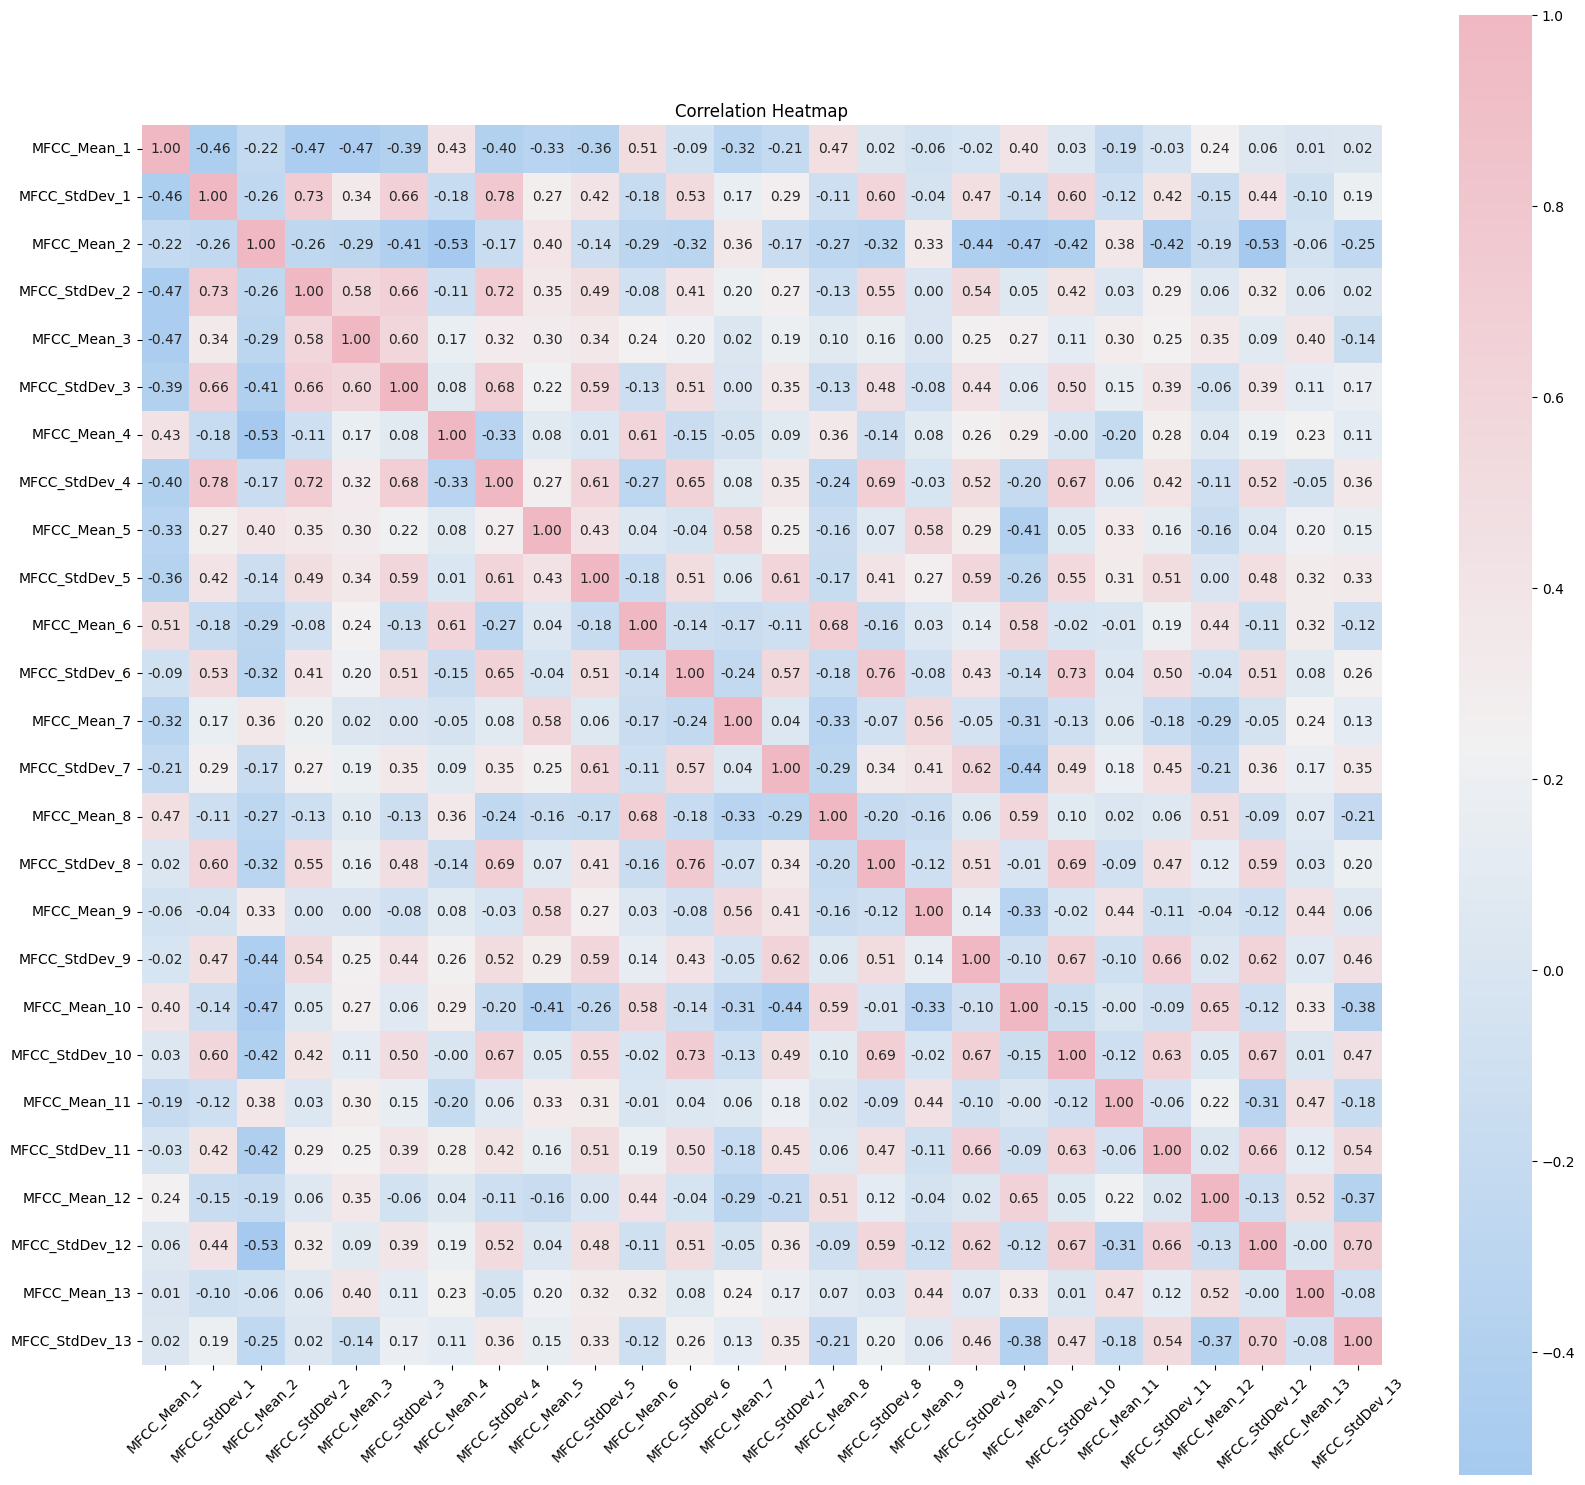

In [7]:
import seaborn as sns

# Удаляем столбец 'filename' из DataFrame
df_without_filename = df.drop(columns=['filename'])

fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Correlation Heatmap')
cmap = sns.diverging_palette(240, 0, s=70, l=80, as_cmap=True)
ax_sns = sns.heatmap(ax=ax, data=df_without_filename.corr(), cmap=cmap, square=True, annot=True, fmt='.2f', linecolor='white')
ax_sns.set_xticklabels(ax_sns.get_xticklabels(), rotation=45)
ax_sns.set_yticklabels(ax_sns.get_yticklabels(), rotation=0)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

def encoding(series):
    codes, uniques = pd.factorize(series.values)
    series = pd.Series(codes)
    return series

print(df.columns)
df['filename'] = encoding(df['filename'])
all_cols = list(df.columns)
mm_scaler = StandardScaler()
features_scaled = mm_scaler.fit_transform(df)
df_scaled = pd.DataFrame(features_scaled, columns=all_cols)
df_scaled

print(round(df_scaled.describe(), 2))
csv_path = 'norm_songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

df_scaled.to_csv(csv_path, index=False)

Index(['filename', 'MFCC_Mean_1', 'MFCC_StdDev_1', 'MFCC_Mean_2',
       'MFCC_StdDev_2', 'MFCC_Mean_3', 'MFCC_StdDev_3', 'MFCC_Mean_4',
       'MFCC_StdDev_4', 'MFCC_Mean_5', 'MFCC_StdDev_5', 'MFCC_Mean_6',
       'MFCC_StdDev_6', 'MFCC_Mean_7', 'MFCC_StdDev_7', 'MFCC_Mean_8',
       'MFCC_StdDev_8', 'MFCC_Mean_9', 'MFCC_StdDev_9', 'MFCC_Mean_10',
       'MFCC_StdDev_10', 'MFCC_Mean_11', 'MFCC_StdDev_11', 'MFCC_Mean_12',
       'MFCC_StdDev_12', 'MFCC_Mean_13', 'MFCC_StdDev_13'],
      dtype='object')
       filename  MFCC_Mean_1  MFCC_StdDev_1  MFCC_Mean_2  MFCC_StdDev_2  \
count    126.00       126.00         126.00       126.00         126.00   
mean      -0.00        -0.00          -0.00        -0.00          -0.00   
std        1.00         1.00           1.00         1.00           1.00   
min       -1.72        -2.24          -1.55        -2.71          -1.97   
25%       -0.86        -0.83          -0.67        -0.70          -0.75   
50%        0.00         0.17          -0.3

In [16]:
from sklearn.preprocessing import StandardScaler

# Сохраняем оригинальные значения 'filename'
original_filenames = df['filename']

# Кодируем уникальные значения 'filename'
filename_mapping, df['filename'] = pd.factorize(df['filename'])

# Стандартизируем числовые данные
mm_scaler = StandardScaler()
features_scaled = mm_scaler.fit_transform(df_without_filename)
df_scaled_numeric = pd.DataFrame(features_scaled, columns=df_without_filename.columns)

# Объединяем стандартизованные числовые данные с оригинальными значениями 'filename'
df_scaled = pd.concat([original_filenames, df_scaled_numeric], axis=1)

print(round(df_scaled.describe(), 2))

csv_path = 'norm_songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

df_scaled.to_csv(csv_path, index=False)

       MFCC_Mean_1  MFCC_StdDev_1  MFCC_Mean_2  MFCC_StdDev_2  MFCC_Mean_3  \
count       126.00         126.00       126.00         126.00       126.00   
mean          0.00           0.00        -0.00           0.00        -0.00   
std           1.00           1.00         1.00           1.00         1.00   
min          -2.24          -1.55        -2.71          -1.97        -1.83   
25%          -0.83          -0.67        -0.70          -0.75        -0.71   
50%           0.17          -0.35        -0.19          -0.14        -0.08   
75%           0.92           0.38         0.53           0.52         0.72   
max           1.76           3.32         3.09           3.43         2.50   

       MFCC_StdDev_3  MFCC_Mean_4  MFCC_StdDev_4  MFCC_Mean_5  MFCC_StdDev_5  \
count         126.00       126.00         126.00       126.00         126.00   
mean            0.00        -0.00           0.00        -0.00          -0.00   
std             1.00         1.00           1.00         

### Обработка дискретизированного аудиофайла

In [ ]:
n_fft = 8195
sr = 22050
hop_length = n_fft // 2
segment_duration = 20  # Длительность каждого сегмента в секундах
segment_samples = segment_duration * sr  # Количество отсчетов в каждом сегменте

def segment_audio(signal, sr, segment_duration):
    # Разбиваем аудиозапись на сегменты по segment_duration секунд
    segments = []
    for start_sample in range(0, len(signal), segment_duration * sr):
        segment = signal[start_sample:start_sample + segment_duration * sr]
        # Если сегмент короче ожидаемой длительности, дополним его нулями
        if len(segment) < segment_duration * sr:
            segment = np.concatenate([segment, np.zeros(segment_duration * sr - len(segment))])
        segments.append(segment)
    return segments

def extract_features(signal):
    features = {}
    features['spectrum_mean'], features['spectrum_var'] = spectrum_feature(signal)
    features['db_spectrum_mean'], features['db_spectrum_var'] = db_spectrum_feature(signal)
    features['melspectrum_mean'], features['melspectrum_var'] = melspectrum_feature(signal)
    features['db_melspectrum_mean'], features['db_melspectrum_var'] = db_melspectrum_feature(signal)
    features['spectral_cent_mean'], features['spectral_cent_var'] = spectral_cent_feature(signal)
    features['spectral_rolloff_mean'], features['spectral_rolloff_var'] = spectral_rolloff_feature(signal)
    features['zero_crossing_mean'], features['zero_crossing_var'] = zero_crossing_feature(signal)
    return features


csv_path = 'songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

# Путь к папке с аудиокомпозициями
songs_dir = 'songs/'

# Список имен файлов в папке songs
file_names = os.listdir(songs_dir)

# Создание пустого списка для хранения словарей признаков
segments_data = []

# Добавление признаков в DataFrame для каждого сегмента каждой композиции

for filename in file_names:
    file_path = os.path.join(songs_dir, filename)
    signal, sr = librosa.load(file_path, sr=sr)
    segments = segment_audio(signal, sr, segment_duration)
    for i, segment in enumerate(segments):
        # Обрезаем тишину в начале и в конце сегмента
        segment, _ = librosa.effects.trim(segment) # эта строка убирается, если тишину необходимо оставить
        features = extract_features(segment)
        segment_data = {'filename': f"{filename[:-4]}_{i+1}", **features}
        segments_data.append(segment_data)

# Создание DataFrame из списка словарей
df = pd.DataFrame(segments_data)

# Вывод DataFrame
print(df)
df.to_csv(csv_path, index=False)


In [ ]:
import numpy as np
import os
import pandas as pd
import librosa
from scipy.stats import moment

n_fft = 8195
sr = 22050
hop_length = n_fft // 2
segment_duration = 20  # Длительность каждого сегмента в секундах
segment_samples = segment_duration * sr  # Количество отсчетов в каждом сегменте

def segment_audio(signal, sr, segment_duration, overlap):
    # Разбиваем аудиозапись на сегменты по segment_duration секунд с перекрытием overlap
    segments = []
    start = 0
    while start + segment_duration <= len(signal) / sr:
        segment = signal[int(start * sr): int((start + segment_duration) * sr)]
        # Если сегмент короче ожидаемой длительности, дополним его нулями
        if len(segment) < segment_duration * sr:
            segment = np.concatenate([segment, np.zeros(segment_duration * sr - len(segment))])
        segments.append(segment)
        start += overlap
    return segments

def extract_features(signal):
    features = {}
    features['spectrum_mean'], features['spectrum_var'] = spectrum_feature(signal)
    features['db_spectrum_mean'], features['db_spectrum_var'] = db_spectrum_feature(signal)
    features['melspectrum_mean'], features['melspectrum_var'] = melspectrum_feature(signal)
    features['db_melspectrum_mean'], features['db_melspectrum_var'] = db_melspectrum_feature(signal)
    features['spectral_cent_mean'], features['spectral_cent_var'] = spectral_cent_feature(signal)
    features['spectral_rolloff_mean'], features['spectral_rolloff_var'] = spectral_rolloff_feature(signal)
    features['zero_crossing_mean'], features['zero_crossing_var'] = zero_crossing_feature(signal)
    return features


csv_path = 'songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

# Путь к папке с аудиокомпозициями
songs_dir = 'songs/'

# Список имен файлов в папке songs
file_names = os.listdir(songs_dir)

# Создание пустого списка для хранения словарей признаков
segments_data = []

# Добавление признаков в DataFrame для каждого сегмента каждой композиции

for filename in file_names:
    file_path = os.path.join(songs_dir, filename)
    signal, sr = librosa.load(file_path, sr=sr)
    segments = segment_audio(signal, sr, segment_duration, segment_duration - 5)  # Изменение с перекрытием
    for i, segment in enumerate(segments):
        # Обрезаем тишину в начале и в конце сегмента
        segment, _ = librosa.effects.trim(segment) # эта строка убирается, если тишину необходимо оставить
        features = extract_features(segment)
        segment_data = {'filename': f"{filename[:-4]}_{i+1}", **features}
        segments_data.append(segment_data)

# Создание DataFrame из списка словарей
df = pd.DataFrame(segments_data)

# Вывод DataFrame
print(df)
df.to_csv(csv_path, index=False)


## Тестирование

In [ ]:
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/Timbaland_-_Apologize_47972715.mp3'
signal = librosa.load(filename_new, sr=22050)[0] #, duration=20
spectrum_mean, spectrum_var = spectrum_feature(signal)
db_spectrum_mean, db_spectrum_var = db_spectrum_feature(signal)
melspectrum_mean, melspectrum_var = melspectrum_feature(signal)
db_melspectrum_mean, db_melspectrum_var = db_melspectrum_feature(signal)
spectral_cent_mean, spectral_cent_var = spectral_cent_feature(signal)
spectral_rolloff_mean, spectral_rolloff_var = spectral_rolloff_feature(signal)
zero_crossing_mean, zero_crossing_var = zero_crossing_feature(signal)

new_features = [spectrum_mean, spectrum_var, db_spectrum_mean, db_spectrum_var, melspectrum_mean, melspectrum_var, db_melspectrum_mean, db_melspectrum_var, spectral_cent_mean, spectral_cent_var, spectral_rolloff_mean, spectral_rolloff_var, zero_crossing_mean, zero_crossing_var]
new_features = np.array(new_features).reshape(1, -1)



X = df.drop(columns=['filename'])
print(X)
print('Features:')
print(new_features)

### Поиск по дистанциям

In [ ]:
# Вычислите расстояния между наборами признаков
distances = np.linalg.norm(X.values - new_features, axis=1)

# Найдите индексы строк с минимальными расстояниями (включая самый близкий)
closest_indices = np.argsort(distances)[:11]  # Выбираем первые четыре индекса с наименьшими расстояниями

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[closest_indices[i]])


### Поиск по сумме дистанций фрагментов (только для дискретизованных)

In [ ]:
# Создайте словарь для хранения сумм расстояний по композициям
sum_distances = {}

# Проход по каждой строке DataFrame X (признаки каждого фрагмента)
for index, row in df.iterrows():
    # Преобразуйте индекс в строку и получите название композиции из индекса строки
    composition_name = row['filename'].split('_')[0]
    
    # Если композиция еще не добавлена в словарь, добавьте ее
    if composition_name not in sum_distances:
        sum_distances[composition_name] = 0
    
    # Вычислите расстояние между текущим фрагментом и новой композицией
    distance = np.linalg.norm(X.values - new_features)
    
    # Добавьте расстояние к сумме расстояний для данной композиции
    sum_distances[composition_name] += distance

# Преобразуйте словарь в DataFrame для удобства обработки
sum_distances_df = pd.DataFrame(list(sum_distances.items()), columns=['Composition', 'Sum Distance'])

# Найдите наиболее похожие композиции на основе сумм расстояний
closest_compositions = sum_distances_df.nsmallest(11, 'Sum Distance')

# Выведите результаты
print("Наиболее похожие композиции:")
for index, row in closest_compositions.iterrows():
    print(f"{row['Composition']}, Сумма расстояний: {row['Sum Distance']}")


### Поиск для MFCC

### Загрузка файла

In [9]:
df = pd.read_csv('norm_songs_features.csv')
filename_new = 'test_data/Timbaland_feat_OneRepublic_-_Apologize_NORTKASH_Zusebi_Remix_73927193.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

X = df.drop(columns=['filename'])
print('Features:')
print(new_features)

Features:
[[-2.79062164e+02  9.81874771e+01  1.55698334e+02  5.44654579e+01
   1.57122917e+01  3.68546371e+01  3.23547440e+01  3.17071018e+01
   7.65785456e+00  1.68530464e+01  1.50993824e+01  1.59104233e+01
   4.79303741e+00  1.04169302e+01  5.60571718e+00  1.47617292e+01
   1.71552563e+00  1.23163395e+01 -9.36045706e-01  1.00283155e+01
  -1.95086256e-01  8.04045963e+00 -1.35133984e-02  7.22135305e+00
   4.10704470e+00  6.39779472e+00]]


In [10]:
# Вычислите расстояния между наборами признаков
distances = np.linalg.norm(X.values - new_features, axis=1)

# Найдите индексы строк с минимальными расстояниями (включая самый близкий)
closest_indices = np.argsort(distances)[:11]  # Выбираем первые четыре индекса с наименьшими расстояниями

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[closest_indices[i]])

Признаки новой композиции:
[[-2.79062164e+02  9.81874771e+01  1.55698334e+02  5.44654579e+01
   1.57122917e+01  3.68546371e+01  3.23547440e+01  3.17071018e+01
   7.65785456e+00  1.68530464e+01  1.50993824e+01  1.59104233e+01
   4.79303741e+00  1.04169302e+01  5.60571718e+00  1.47617292e+01
   1.71552563e+00  1.23163395e+01 -9.36045706e-01  1.00283155e+01
  -1.95086256e-01  8.04045963e+00 -1.35133984e-02  7.22135305e+00
   4.10704470e+00  6.39779472e+00]]

Другие похожие файлы и их признаки:

Файл 1: -0.23369675485198
[-1.80749904  2.94449392 -1.28715874  3.14779008  2.11241414  2.08121719
  0.12698074  1.77122183  1.7558421   1.25629942 -0.1128355   0.6737334
  1.49872198  0.1946143   0.94731603  1.57616324  0.35544014  1.74232359
  0.70552298  0.86806163 -0.05827953 -0.28331807  0.28507016 -0.15015598
  0.01310499 -1.20782949]
Расстояние: 343.51044764482697

Файл 2: 0.5086341135013683
[-1.53345267  2.7969222   1.55719229  0.64282522 -0.12023403  0.1599491
 -3.26989224  3.35802311  0.6

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Загрузка данных
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/7 Seconds from middle small.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

# Исключаем столбец с именем файла
X = df.drop(columns=['filename'])

# Создание модели kNN
k = 11  # количество соседей
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X)

# Поиск ближайших соседей
distances, indices = knn.kneighbors(new_features)

# Получение информации о ближайших соседях
closest_files = df.iloc[indices[0]]['filename']
closest_features = X.iloc[indices[0]].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_files)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[0][i])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Загрузка данных
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/7 Seconds from middle small.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

X = df.drop(columns=['filename'])

# Вычислите косинусное сходство между наборами признаков
similarities = cosine_similarity(X, new_features)

# Найдите индексы строк с максимальным косинусным сходством (включая самый близкий)
closest_indices = np.argsort(similarities, axis=0)[-11:].flatten()

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Косинусное сходство:", similarities[closest_indices[i]][0])

In [ ]:
# Создайте словарь для хранения сумм расстояний по композициям
sum_distances = {}

# Проход по каждой строке DataFrame X (признаки каждого фрагмента)
for index, row in df.iterrows():
    # Преобразуйте индекс в строку и получите название композиции из индекса строки
    composition_name = row['filename'].split('_')[0]
    
    # Если композиция еще не добавлена в словарь, добавьте ее
    if composition_name not in sum_distances:
        sum_distances[composition_name] = 0
    
    # Вычислите евклидово расстояние между текущим фрагментом и новой композицией
    distance = np.linalg.norm(row.values[1:] - new_features)
    
    # Добавьте расстояние к сумме расстояний для данной композиции
    sum_distances[composition_name] += distance

# Преобразуйте словарь в DataFrame для удобства обработки
sum_distances_df = pd.DataFrame(list(sum_distances.items()), columns=['Composition', 'Sum Distance'])

closest_compositions = sum_distances_df.nsmallest(11, 'Sum Distance')

print("Наиболее похожие композиции:")
for index, row in closest_compositions.iterrows():
    print(f"{row['Composition']}, Сумма расстояний: {row['Sum Distance']}")


## Предобработка всех файлов директории, создание датафрейма

In [34]:
n_fft = 8195
sr = 22050
hop_length = n_fft // 2

def spectrum_feature(signal):
    ft = np.abs(librosa.stft(signal[:n_fft], n_fft=n_fft, hop_length=hop_length))
    mean_ft = np.mean(ft, axis=1)  # Усредняем по всем каналам

    return np.mean(mean_ft), np.var(mean_ft)

def db_spectrum_feature(signal):
    X = librosa.stft(signal)
    s = librosa.amplitude_to_db(abs(X))

    return np.mean(s), np.var(s)

def melspectrum_feature(signal):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc = 40, hop_length=512)

    return np.mean(mfccs), np.var(mfccs)

def db_melspectrum_feature(signal):
    melspectrum = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=512, n_mels=40)
    melspectrum_db = librosa.power_to_db(melspectrum, ref=np.max)  # Преобразуем в децибелы

    return np.mean(melspectrum_db), np.var(melspectrum_db)

def spectral_cent_feature(signal):
    cent = librosa.feature.spectral_centroid(y=signal, sr=sr)

    return np.mean(cent), np.var(cent)

def spectral_rolloff_feature(signal):
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)

    return np.mean(rolloff), np.var(rolloff)

def zero_crossing_feature(signal):
    zrate=librosa.feature.zero_crossing_rate(signal)

    return np.mean(zrate), np.var(zrate)

### Обработка аудиофайлов целиком

In [6]:
# Функция для вычисления мел-кепстральных коэффициентов
def compute_mfcc(audio, sr=22050, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Функция для разбиения аудио на фрагменты по 20 секунд
def split_audio(audio, sr=22050, fragment_length=20):
    fragment_samples = fragment_length * sr
    num_fragments = len(audio) // fragment_samples
    fragments = [audio[i*fragment_samples:(i+1)*fragment_samples] for i in range(num_fragments)]
    return fragments

# Функция для разбиения мел-кепстральных коэффициентов на группы по 20 элементов
def split_mfcc(mfccs, group_size=20):
    num_frames = mfccs.shape[1]
    num_groups = num_frames // group_size
    mfcc_groups = [mfccs[:, i*group_size:(i+1)*group_size] for i in range(num_groups)]
    return mfcc_groups

# Функция для обработки отдельного аудиофайла
def process_audio(file_path, max_duration, fragment_length=20, group_size=20):
    try:
        audio, sr = librosa.load(file_path, sr=None, duration=max_duration)
        audio_length = librosa.get_duration(y=audio, sr=sr)
        if audio_length < fragment_length:
            return None
        fragments = split_audio(audio, sr, fragment_length)
        data = []
        filename = os.path.splitext(os.path.basename(file_path))[0]
        for i, fragment in enumerate(fragments):
            mfccs = compute_mfcc(fragment, sr)
            mfcc_groups = split_mfcc(mfccs, group_size)
            fragment_data = {'filename': f"{filename}_{i+1}"}
            for j, group in enumerate(mfcc_groups):
                mean = np.mean(group, axis=1)
                std_dev = np.std(group, axis=1)
                for k in range(mean.shape[0]):
                    fragment_data[f'MFCC_Mean_{(j*group_size)+k+1}'] = mean[k]
                    fragment_data[f'MFCC_StdDev_{(j*group_size)+k+1}'] = std_dev[k]
            data.append(fragment_data)
        return data
    except Exception as e:
        print(f"Error processing audio {file_path}: {e}")
        return None



# Функция для обработки всех аудиофайлов в директории
def process_directory(directory_path, fragment_length=20, group_size=20, max_duration=60):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.mp3'):
            file_path = os.path.join(directory_path, filename)
            result = process_audio(file_path, max_duration, fragment_length, group_size)
            if result is not None:
                data.extend(result)
    return data

# Путь к директории с аудиофайлами
directory_path = 'songs'
# Обработка всех аудиофайлов в директории
data = process_directory(directory_path)

csv_path = 'songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

# Создание датафрейма из полученных данных
df = pd.DataFrame(data)

# Вывод датафрейма
print(df)
csv_path = 'songs_features.csv'
df.to_csv(csv_path, index=False)

Файл 'songs_features.csv' очищен успешно.
                                             filename  MFCC_Mean_1  \
0         7 Seconds -- Youssou N'Dour, Neneh Cherry_1  -551.628662   
1         7 Seconds -- Youssou N'Dour, Neneh Cherry_2  -140.451599   
2         7 Seconds -- Youssou N'Dour, Neneh Cherry_3  -170.317963   
3                                a-ha -- Take On Me_1  -540.525757   
4                                a-ha -- Take On Me_2  -126.084801   
5                                a-ha -- Take On Me_3   -64.118607   
6                       ABBA -- Money, Money, Money_1  -543.826843   
7                       ABBA -- Money, Money, Money_2  -212.842972   
8                       ABBA -- Money, Money, Money_3  -137.955460   
9                   ABBA -- The Winner Takes It All_1  -698.643555   
10                  ABBA -- The Winner Takes It All_2  -212.278900   
11                  ABBA -- The Winner Takes It All_3  -301.265747   
12                          All The Things She S

In [40]:
df.columns

Index(['filename', 'spectrum_feature_mean', 'spectrum_feature_var',
       'db_spectrum_feature_mean', 'db_spectrum_feature_var',
       'melspectrum_feature_mean', 'melspectrum_feature_var',
       'db_melspectrum_feature_mean', 'db_melspectrum_feature_var',
       'spectral_cent_feature_mean', 'spectral_cent_feature_var',
       'spectral_rolloff_feature_mean', 'spectral_rolloff_feature_var',
       'zero_crossing_feature_mean', 'zero_crossing_feature_var'],
      dtype='object')

### Обработка дискретизированного аудиофайла

In [ ]:
import numpy as np
import os
import pandas as pd
import librosa
from scipy.stats import moment

n_fft = 8195
sr = 22050
hop_length = n_fft // 2
segment_duration = 20  # Длительность каждого сегмента в секундах
segment_samples = segment_duration * sr  # Количество отсчетов в каждом сегменте

def segment_audio(signal, sr, segment_duration, overlap):
    # Разбиваем аудиозапись на сегменты по segment_duration секунд с перекрытием overlap
    segments = []
    start = 0
    while start + segment_duration <= len(signal) / sr:
        segment = signal[int(start * sr): int((start + segment_duration) * sr)]
        # Если сегмент короче ожидаемой длительности, дополним его нулями
        if len(segment) < segment_duration * sr:
            segment = np.concatenate([segment, np.zeros(segment_duration * sr - len(segment))])
        segments.append(segment)
        start += overlap
    return segments

def extract_features(signal):
    features = {}
    features['spectrum_mean'], features['spectrum_var'] = spectrum_feature(signal)
    features['db_spectrum_mean'], features['db_spectrum_var'] = db_spectrum_feature(signal)
    features['melspectrum_mean'], features['melspectrum_var'] = melspectrum_feature(signal)
    features['db_melspectrum_mean'], features['db_melspectrum_var'] = db_melspectrum_feature(signal)
    features['spectral_cent_mean'], features['spectral_cent_var'] = spectral_cent_feature(signal)
    features['spectral_rolloff_mean'], features['spectral_rolloff_var'] = spectral_rolloff_feature(signal)
    features['zero_crossing_mean'], features['zero_crossing_var'] = zero_crossing_feature(signal)
    return features


csv_path = 'songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

# Путь к папке с аудиокомпозициями
songs_dir = 'songs/'

# Список имен файлов в папке songs
file_names = os.listdir(songs_dir)

# Создание пустого списка для хранения словарей признаков
segments_data = []

# Добавление признаков в DataFrame для каждого сегмента каждой композиции

for filename in file_names:
    file_path = os.path.join(songs_dir, filename)
    signal, sr = librosa.load(file_path, sr=sr)
    segments = segment_audio(signal, sr, segment_duration, segment_duration - 5)  # Изменение с перекрытием
    for i, segment in enumerate(segments):
        # Обрезаем тишину в начале и в конце сегмента
        segment, _ = librosa.effects.trim(segment) # эта строка убирается, если тишину необходимо оставить
        features = extract_features(segment)
        segment_data = {'filename': f"{filename[:-4]}_{i+1}", **features}
        segments_data.append(segment_data)

# Создание DataFrame из списка словарей
df = pd.DataFrame(segments_data)

# Вывод DataFrame
print(df)
df.to_csv(csv_path, index=False)


Файл 'songs_features.csv' очищен успешно.
                                        filename  spectrum_mean  spectrum_var  \
0    7 Seconds -- Youssou N'Dour, Neneh Cherry_1       0.009078      0.001058   
1    7 Seconds -- Youssou N'Dour, Neneh Cherry_2       1.532228     26.641769   
2    7 Seconds -- Youssou N'Dour, Neneh Cherry_3       1.652172     30.376503   
3    7 Seconds -- Youssou N'Dour, Neneh Cherry_4       2.186472     34.958107   
4    7 Seconds -- Youssou N'Dour, Neneh Cherry_5       2.133529     49.443848   
..                                           ...            ...           ...   
204             Bag Raiders -- Shooting stars_10       2.832639     34.444614   
205             Bag Raiders -- Shooting stars_11       5.193159     94.942253   
206             Bag Raiders -- Shooting stars_12       6.934866    129.035187   
207             Bag Raiders -- Shooting stars_13       8.448624    131.645828   
208             Bag Raiders -- Shooting stars_14       6.249237    

## Тестирование

In [ ]:
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/Apologize-2-middle.mp3'
signal = librosa.load(filename_new, sr=22050, duration=20)[0]
spectrum_mean, spectrum_var = spectrum_feature(signal)
db_spectrum_mean, db_spectrum_var = db_spectrum_feature(signal)
melspectrum_mean, melspectrum_var = melspectrum_feature(signal)
db_melspectrum_mean, db_melspectrum_var = db_melspectrum_feature(signal)
spectral_cent_mean, spectral_cent_var = spectral_cent_feature(signal)
spectral_rolloff_mean, spectral_rolloff_var = spectral_rolloff_feature(signal)
zero_crossing_mean, zero_crossing_var = zero_crossing_feature(signal)

new_features = [spectrum_mean, spectrum_var, db_spectrum_mean, db_spectrum_var, melspectrum_mean, melspectrum_var, db_melspectrum_mean, db_melspectrum_var, spectral_cent_mean, spectral_cent_var, spectral_rolloff_mean, spectral_rolloff_var, zero_crossing_mean, zero_crossing_var]
new_features = np.array(new_features).reshape(1, -1)



X = df.drop(columns=['filename'])
print(X)
print('Features:')
print(new_features)

     MFCC_Mean_1  MFCC_StdDev_1  MFCC_Mean_2  MFCC_StdDev_2  MFCC_Mean_3  \
0     -220.85213     114.887590    127.10273      43.040510    -8.352807   
1     -177.18689      53.960754    141.07071      30.124899    -2.857252   
2     -175.85992      55.398660    142.48146      31.485120    -5.452794   
3     -168.87038      55.242714    140.69824      30.286985    -5.928559   
4     -158.13608      53.203526    136.64862      29.569930    -5.854443   
..           ...            ...          ...            ...          ...   
121   -153.23734      99.889580    131.10143      42.562866   -19.374846   
122   -112.45278      53.073340    144.73102      31.210810   -26.030530   
123   -105.96795      51.869790    145.87883      31.456564   -26.110855   
124    -99.75491      50.877182    147.28088      31.200481   -25.592222   
125    -92.13892      49.087082    147.55724      31.178919   -27.464697   

     MFCC_StdDev_3  MFCC_Mean_4  MFCC_StdDev_4  MFCC_Mean_5  MFCC_StdDev_5  \
0        

### Поиск по дистанциям

In [ ]:
# Вычислите расстояния между наборами признаков
distances = np.linalg.norm(X.values - new_features, axis=1)

# Найдите индексы строк с минимальными расстояниями (включая самый близкий)
closest_indices = np.argsort(distances)[:11]  # Выбираем первые четыре индекса с наименьшими расстояниями

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[closest_indices[i]])


Признаки новой композиции:
[[ 2.13182181e-01  1.36200696e-01 -1.56148434e+01  1.71010300e+02
  -5.83144999e+00  1.34914783e+03 -4.06267128e+01  1.08680252e+02
   3.26104732e+03  1.00281438e+06  6.04835701e+03  2.39416217e+06
   2.16268942e-01  1.06125299e-02]]

Другие похожие файлы и их признаки:

Файл 1: a-ha -- Take On Me_1
[ 7.81158570e-01  1.26830220e+01 -8.87243750e+00  1.88163860e+02
 -1.21255584e-01  8.93305360e+02 -3.81384430e+01  1.38960900e+02
  2.98754398e+03  1.05525533e+06  6.10673505e+03  2.43394323e+06
  1.56221752e-01  1.04303321e-02]
Расстояние: 65824.56181555991

Файл 2: B.o.B, Jessie J -- Price Tag_3
[ 3.10073880e+00  6.79195700e+01 -1.30734850e+00  1.53659450e+02
  1.67803180e+00  3.82020480e+02 -3.38683200e+01  1.05749980e+02
  3.04004371e+03  9.11873672e+05  6.29234169e+03  2.53493347e+06
  1.43397780e-01  8.00094914e-03]
Расстояние: 167594.21122022573

Файл 3: B.o.B, Jessie J -- Price Tag_8
[ 4.49689250e+00  1.74120900e+02  1.70286810e+00  1.38811070e+02
  2.8523

### Поиск по сумме дистанций фрагментов (только для дискретизованных)

In [ ]:
# Создайте словарь для хранения сумм расстояний по композициям
sum_distances = {}

# Проход по каждой строке DataFrame X (признаки каждого фрагмента)
for index, row in df.iterrows():
    # Преобразуйте индекс в строку и получите название композиции из индекса строки
    composition_name = row['filename'].split('_')[0]
    
    # Если композиция еще не добавлена в словарь, добавьте ее
    if composition_name not in sum_distances:
        sum_distances[composition_name] = 0
    
    # Вычислите расстояние между текущим фрагментом и новой композицией
    distance = np.linalg.norm(X.values - new_features)
    
    # Добавьте расстояние к сумме расстояний для данной композиции
    sum_distances[composition_name] += distance

# Преобразуйте словарь в DataFrame для удобства обработки
sum_distances_df = pd.DataFrame(list(sum_distances.items()), columns=['Composition', 'Sum Distance'])

# Найдите наиболее похожие композиции на основе сумм расстояний
closest_compositions = sum_distances_df.nsmallest(11, 'Sum Distance')

# Выведите результаты
print("Наиболее похожие композиции:")
for index, row in closest_compositions.iterrows():
    print(f"{row['Composition']}, Сумма расстояний: {row['Sum Distance']}")


Наиболее похожие композиции:
Apologize, Сумма расстояний: 401798842.77883863
B.o.B, Hayley Williams of Paramore -- Airplanes (feat. Hayley Williams of Paramore), Сумма расстояний: 401798842.77883863
ABBA -- Money, Money, Money, Сумма расстояний: 438326010.3041876
All The Things She Said, Сумма расстояний: 474853177.82953656
Another One Bites The Dust — Queen, Сумма расстояний: 474853177.82953656
Bad Bad Boys, Сумма расстояний: 474853177.82953656
a-ha -- Take On Me, Сумма расстояний: 511380345.3548855
B.o.B, Jessie J -- Price Tag, Сумма расстояний: 511380345.3548855
Bag Raiders -- Shooting stars, Сумма расстояний: 511380345.3548855
Appletree, Сумма расстояний: 620961847.9309325
ABBA -- The Winner Takes It All, Сумма расстояний: 694016182.9816306


### Поиск для MFCC

### Загрузка файла

In [32]:
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/Bad-romance-2-middle-bad.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

X = df.drop(columns=['filename'])
print('Features:')
print(new_features)

Features:
[[-267.83646     54.75637    111.99199     22.37832   -100.97644
    15.945072    23.327       16.3218     -15.9615135   13.002825
    11.625529    13.705842     3.9138842   14.234419     6.2534366
    11.410356     6.0041423   10.736979     2.8875127    8.843429
    -6.9074903    7.4020934    4.5167303    7.6583266    3.527846
     7.837398 ]]


In [33]:
# Вычислите расстояния между наборами признаков
distances = np.linalg.norm(X.values - new_features, axis=1)

# Найдите индексы строк с минимальными расстояниями (включая самый близкий)
closest_indices = np.argsort(distances)[:11]  # Выбираем первые четыре индекса с наименьшими расстояниями

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[closest_indices[i]])

Признаки новой композиции:
[[-267.83646     54.75637    111.99199     22.37832   -100.97644
    15.945072    23.327       16.3218     -15.9615135   13.002825
    11.625529    13.705842     3.9138842   14.234419     6.2534366
    11.410356     6.0041423   10.736979     2.8875127    8.843429
    -6.9074903    7.4020934    4.5167303    7.6583266    3.527846
     7.837398 ]]

Другие похожие файлы и их признаки:

Файл 1: ABBA -- The Winner Takes It All_6
[-244.38443     52.2417     154.38762     26.183445   -33.70895
   18.987246    32.008736    15.551234   -17.501093    15.656606
   10.209758    13.7289505   -8.646806    13.018318    12.0814295
    8.931306    -8.558696     7.8139863   -4.1696157    8.7188
   -3.894312     7.2958994   -5.3892455    7.532467   -11.136696
    7.3806105]
Расстояние: 88.21584740702484

Файл 2: ABBA -- The Winner Takes It All_7
[-242.1219      56.183258   146.11101     25.982256   -30.88678
   17.462172    36.58471     16.804033   -20.305653    16.90045
   14.0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Загрузка данных
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/Timbaland_-_Apologize_47972715.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

# Исключаем столбец с именем файла
X = df.drop(columns=['filename'])

# Создание модели kNN
k = 11  # количество соседей
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X)

# Поиск ближайших соседей
distances, indices = knn.kneighbors(new_features)

# Получение информации о ближайших соседях
closest_files = df.iloc[indices[0]]['filename']
closest_features = X.iloc[indices[0]].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_files)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[0][i])

Признаки новой композиции:
[[-288.06668      60.70743     205.97404      35.046642      0.88057715
    18.081236      5.963103     17.07417      32.294445     19.088327
    22.034721     10.259438      5.390159      8.801256     14.262574
     8.576096      0.7318664     6.9426675     3.1005921     7.1525445
    12.621408      7.337948      8.772374      7.5816245     2.5928311
     8.000182  ]]

Другие похожие файлы и их признаки:

Файл 1: Apologize_1
[-294.52026     63.7023     205.26846     36.558174    -1.3206267
   17.917377     7.096078    18.065292    31.859001    20.555147
   22.141106    11.167155     4.8725834    9.429071    14.648979
    8.976401     0.6256216    7.383997     3.137099     7.1677046
   12.515677     7.437581     8.612726     7.5203185    2.8586743
    8.008733 ]
Расстояние: 8.063209715429508

Файл 2: Apologize_2
[-273.92856      60.157997    200.76419      29.322891     -2.8187664
   19.171198     13.79775      19.595463     24.43775      20.477089
   24.1965

c:\Users\ccoo0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
# Загрузка данных
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/Timbaland_-_Apologize_47972715.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

X = df.drop(columns=['filename'])

# Вычислите косинусное сходство между наборами признаков
similarities = cosine_similarity(X, new_features)

# Найдите индексы строк с максимальным косинусным сходством (включая самый близкий)
closest_indices = np.argsort(similarities, axis=0)[-11:].flatten()

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Косинусное сходство:", similarities[closest_indices[i]][0])

Признаки новой композиции:
[[-288.06668      60.70743     205.97404      35.046642      0.88057715
    18.081236      5.963103     17.07417      32.294445     19.088327
    22.034721     10.259438      5.390159      8.801256     14.262574
     8.576096      0.7318664     6.9426675     3.1005921     7.1525445
    12.621408      7.337948      8.772374      7.5816245     2.5928311
     8.000182  ]]

Другие похожие файлы и их признаки:

Файл 1: Appletree_7
[-231.18248     76.3363     135.57071     33.917816     5.7404075
   37.60667     50.063606    24.036346    11.8617115   25.029144
   21.831793    17.05817     -8.982225    17.238123     7.915213
   11.770077     3.8364744   11.546842    -1.7997239   12.235502
    6.386862    11.082053     3.0976791    8.966873     1.0490957
    9.104662 ]
Косинусное сходство: 0.9693613651447394

Файл 2: ABBA -- Money, Money, Money_2
[-2.3506900e+02  8.4479256e+01  1.3878201e+02  3.0584091e+01
 -2.2852660e+01  2.1236902e+01  3.9169520e+01  2.0940365e+01


In [ ]:
# Создайте словарь для хранения сумм расстояний по композициям
sum_distances = {}

# Проход по каждой строке DataFrame X (признаки каждого фрагмента)
for index, row in df.iterrows():
    # Преобразуйте индекс в строку и получите название композиции из индекса строки
    composition_name = row['filename'].split('_')[0]
    
    # Если композиция еще не добавлена в словарь, добавьте ее
    if composition_name not in sum_distances:
        sum_distances[composition_name] = 0
    
    # Вычислите евклидово расстояние между текущим фрагментом и новой композицией
    distance = np.linalg.norm(row.values[1:] - new_features)
    
    # Добавьте расстояние к сумме расстояний для данной композиции
    sum_distances[composition_name] += distance

# Преобразуйте словарь в DataFrame для удобства обработки
sum_distances_df = pd.DataFrame(list(sum_distances.items()), columns=['Composition', 'Sum Distance'])

closest_compositions = sum_distances_df.nsmallest(11, 'Sum Distance')

print("Наиболее похожие композиции:")
for index, row in closest_compositions.iterrows():
    print(f"{row['Composition']}, Сумма расстояний: {row['Sum Distance']}")


Наиболее похожие композиции:
Apologize, Сумма расстояний: 944.7098524450187
ABBA -- The Winner Takes It All, Сумма расстояний: 961.290553422826
Appletree, Сумма расстояний: 1048.9091851581397
ABBA -- Money, Money, Money, Сумма расстояний: 1322.7758140737149
Another One Bites The Dust — Queen, Сумма расстояний: 1401.1375403566121
7 Seconds -- Youssou N'Dour, Neneh Cherry, Сумма расстояний: 1439.4468202799699
Animals — Martin Garrix, Сумма расстояний: 1502.9821220101144
Bag Raiders -- Shooting stars, Сумма расстояний: 1616.6491238250806
Bad Bad Boys, Сумма расстояний: 1688.6896462805341
B.o.B, Hayley Williams of Paramore -- Airplanes (feat. Hayley Williams of Paramore), Сумма расстояний: 1718.420444390585
All The Things She Said, Сумма расстояний: 1746.983466280012


In [38]:
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/Timbaland_-_Apologize_47972715.mp3'
signal = librosa.load(filename_new, sr=22050)[0] #, duration=20
spectrum_mean, spectrum_var = spectrum_feature(signal)
db_spectrum_mean, db_spectrum_var = db_spectrum_feature(signal)
melspectrum_mean, melspectrum_var = melspectrum_feature(signal)
db_melspectrum_mean, db_melspectrum_var = db_melspectrum_feature(signal)
spectral_cent_mean, spectral_cent_var = spectral_cent_feature(signal)
spectral_rolloff_mean, spectral_rolloff_var = spectral_rolloff_feature(signal)
zero_crossing_mean, zero_crossing_var = zero_crossing_feature(signal)

new_features = [spectrum_mean, spectrum_var, db_spectrum_mean, db_spectrum_var, melspectrum_mean, melspectrum_var, db_melspectrum_mean, db_melspectrum_var, spectral_cent_mean, spectral_cent_var, spectral_rolloff_mean, spectral_rolloff_var, zero_crossing_mean, zero_crossing_var]
new_features = np.array(new_features).reshape(1, -1)



X = df.drop(columns=['filename'])
print(X)
print('Features:')
print(new_features)

    spectrum_feature_mean  spectrum_feature_var  db_spectrum_feature_mean  \
0            1.415024e-03          5.448380e-06                 -8.287863   
1            8.429581e-04          8.048017e-06                 -3.834793   
2            7.433493e-20          1.894931e-39                 -7.576152   
3            8.187937e-06          3.205970e-11                 -6.590091   
4            6.735864e-02          2.151134e-01                 -2.964818   
5            1.317450e+00          2.668646e+00                 -5.605087   
6            2.534112e+00          8.626266e+01                 -9.704225   
7            5.115468e-01          5.532359e+00                 -6.469716   
8            1.043127e+00          3.236451e+01                -14.959120   
9            1.066156e-01          1.368918e-01                 -2.647291   
10           1.173418e+00          1.380086e+01                 -1.725452   
11           1.118220e-01          5.227377e-02                 -5.999099   

In [39]:
# Вычислите расстояния между наборами признаков
distances = np.linalg.norm(X.values - new_features, axis=1)

# Найдите индексы строк с минимальными расстояниями (включая самый близкий)
closest_indices = np.argsort(distances)[:11]  # Выбираем первые четыре индекса с наименьшими расстояниями

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[closest_indices[i]])


Признаки новой композиции:
[[ 7.47407079e-01  1.84110832e+01 -6.43032694e+00  2.03364059e+02
   2.56333947e+00  7.91432434e+02 -3.96839180e+01  2.15656616e+02
   2.26788371e+03  1.19863457e+06  4.96018372e+03  5.62950714e+06
   9.03437396e-02  4.40387526e-03]]

Другие похожие файлы и их признаки:

Файл 1: Apologize.mp3
[ 5.11546850e-01  5.53235860e+00 -6.46971560e+00  2.02547070e+02
  2.37524150e+00  8.22804930e+02 -4.07967600e+01  2.20416100e+02
  2.32040490e+03  1.27557061e+06  5.04599911e+03  5.74612117e+06
  9.41517279e-02  4.73722360e-03]
Расстояние: 139706.8267316446

Файл 2: Appletree.mp3
[ 1.04312700e+00  3.23645060e+01 -1.49591200e+01  1.76028520e+02
  2.99068900e-01  1.67233090e+03 -4.66821670e+01  2.43737230e+02
  1.98215141e+03  1.19390030e+06  4.26731192e+03  5.23577064e+06
  6.29451775e-02  3.57126172e-03]
Расстояние: 393766.6620908847

Файл 3: Animals — Martin Garrix.mp3
[ 1.31745000e+00  2.66864560e+00 -5.60508730e+00  1.99456090e+02
  1.68426120e+00  6.99968440e+02 -3.

In [ ]:
# Создайте словарь для хранения сумм расстояний по композициям
sum_distances = {}

# Проход по каждой строке DataFrame X (признаки каждого фрагмента)
for index, row in df.iterrows():
    # Преобразуйте индекс в строку и получите название композиции из индекса строки
    composition_name = row['filename'].split('_')[0]
    
    # Если композиция еще не добавлена в словарь, добавьте ее
    if composition_name not in sum_distances:
        sum_distances[composition_name] = 0
    
    # Вычислите расстояние между текущим фрагментом и новой композицией
    distance = np.linalg.norm(X.values - new_features)
    
    # Добавьте расстояние к сумме расстояний для данной композиции
    sum_distances[composition_name] += distance

# Преобразуйте словарь в DataFrame для удобства обработки
sum_distances_df = pd.DataFrame(list(sum_distances.items()), columns=['Composition', 'Sum Distance'])

# Найдите наиболее похожие композиции на основе сумм расстояний
closest_compositions = sum_distances_df.nsmallest(11, 'Sum Distance')

# Выведите результаты
print("Наиболее похожие композиции:")
for index, row in closest_compositions.iterrows():
    print(f"{row['Composition']}, Сумма расстояний: {row['Sum Distance']}")


Наиболее похожие композиции:
Apologize, Сумма расстояний: 401798842.77883863
B.o.B, Hayley Williams of Paramore -- Airplanes (feat. Hayley Williams of Paramore), Сумма расстояний: 401798842.77883863
ABBA -- Money, Money, Money, Сумма расстояний: 438326010.3041876
All The Things She Said, Сумма расстояний: 474853177.82953656
Another One Bites The Dust — Queen, Сумма расстояний: 474853177.82953656
Bad Bad Boys, Сумма расстояний: 474853177.82953656
a-ha -- Take On Me, Сумма расстояний: 511380345.3548855
B.o.B, Jessie J -- Price Tag, Сумма расстояний: 511380345.3548855
Bag Raiders -- Shooting stars, Сумма расстояний: 511380345.3548855
Appletree, Сумма расстояний: 620961847.9309325
ABBA -- The Winner Takes It All, Сумма расстояний: 694016182.9816306


### Загрузка файла

In [17]:
# Вычислите расстояния между наборами признаков
distances = np.linalg.norm(X.values - new_features, axis=1)

# Найдите индексы строк с минимальными расстояниями (включая самый близкий)
closest_indices = np.argsort(distances)[:11]  # Выбираем первые четыре индекса с наименьшими расстояниями

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Расстояние:", distances[closest_indices[i]])

Признаки новой композиции:
[[-2.79062164e+02  9.81874771e+01  1.55698334e+02  5.44654579e+01
   1.57122917e+01  3.68546371e+01  3.23547440e+01  3.17071018e+01
   7.65785456e+00  1.68530464e+01  1.50993824e+01  1.59104233e+01
   4.79303741e+00  1.04169302e+01  5.60571718e+00  1.47617292e+01
   1.71552563e+00  1.23163395e+01 -9.36045706e-01  1.00283155e+01
  -1.95086256e-01  8.04045963e+00 -1.35133984e-02  7.22135305e+00
   4.10704470e+00  6.39779472e+00]]

Другие похожие файлы и их признаки:

Файл 1: Another One Bites The Dust — Queen_1
[-1.80749904  2.94449392 -1.28715874  3.14779008  2.11241414  2.08121719
  0.12698074  1.77122183  1.7558421   1.25629942 -0.1128355   0.6737334
  1.49872198  0.1946143   0.94731603  1.57616324  0.35544014  1.74232359
  0.70552298  0.86806163 -0.05827953 -0.28331807  0.28507016 -0.15015598
  0.01310499 -1.20782949]
Расстояние: 343.51044764482697

Файл 2: B.o.B, Hayley Williams of Paramore -- Airplanes (feat. Hayley Williams of Paramore)_1
[-1.53345267  2

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
# Загрузка данных
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/7 Seconds from middle small.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

X = df.drop(columns=['filename'])

# Вычислите косинусное сходство между наборами признаков
similarities = cosine_similarity(X, new_features)

# Найдите индексы строк с максимальным косинусным сходством (включая самый близкий)
closest_indices = np.argsort(similarities, axis=0)[-11:].flatten()

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Косинусное сходство:", similarities[closest_indices[i]][0])

Признаки новой композиции:
[[-136.94652     48.15086    133.78339     25.045727    -3.4574358
    19.012459    52.906593    12.004604    -9.7661295   17.015518
    45.452053    11.971169   -22.336512    13.349935    21.156645
    10.17392     -1.8026047   10.184543    13.6172285    8.353845
    -8.874034     8.900497    11.079862     7.5026326    1.893026
     6.3978343]]

Другие похожие файлы и их признаки:

Файл 1: Bad Bad Boys_5
[-150.28946     50.68178    122.11754     22.383467   -18.054884
   29.379808    59.9512      17.397646   -11.749435    21.948305
   31.130291    16.501328   -17.769829    13.568505    26.109
   11.274147    -9.232224     9.664581    13.4331665   11.080587
    1.7540551   10.337084     6.979301     8.990133     4.5127983
    6.9244866]
Косинусное сходство: 0.9875544754059715

Файл 2: Bad Bad Boys_7
[-152.31073     51.82261    117.270546    21.034023   -16.460344
   26.94437     65.02995     15.612344   -10.527432    20.826616
   35.888798    15.061704   -17.

In [18]:
from sklearn.metrics.pairwise import euclidean_distances

# Загрузка данных
df = pd.read_csv('songs_features.csv')
filename_new = 'test_data/7 Seconds from middle small.mp3'
result = process_audio(filename_new, 20, fragment_length=20, overlap=5)
result = list(result[0].values())[1:]
new_features = np.array(result).reshape(1, -1)

X = df.drop(columns=['filename'])

# Вычислите евклидово расстояние между наборами признаков
distances = euclidean_distances(X, new_features)

# Найдите индексы строк с минимальным евклидовым расстоянием (включая самый близкий)
closest_indices = np.argsort(distances, axis=0)[:11].flatten()

# Получите названия файлов из найденных строк
closest_files = df.iloc[closest_indices]['filename']

# Получите признаки из найденных строк
closest_features = X.iloc[closest_indices].values

print("Признаки новой композиции:")
print(new_features)

print("\nДругие похожие файлы и их признаки:")
for i in range(len(closest_indices)):
    print(f"\nФайл {i+1}: {closest_files.iloc[i]}")
    print(closest_features[i])
    print("Евклидово расстояние:", distances[closest_indices[i]][0])


Признаки новой композиции:
[[-136.94652     48.15086    133.78339     25.045727    -3.4574358
    19.012459    52.906593    12.004604    -9.7661295   17.015518
    45.452053    11.971169   -22.336512    13.349935    21.156645
    10.17392     -1.8026047   10.184543    13.6172285    8.353845
    -8.874034     8.900497    11.079862     7.5026326    1.893026
     6.3978343]]

Другие похожие файлы и их признаки:

Файл 1: 7 Seconds -- Youssou N'Dour, Neneh Cherry_8
[-145.8422      46.18623    134.98433     27.963745    -4.7078805
   16.527643    56.211025    13.120522    -7.9997125   16.93889
   45.865074    12.995517   -13.453731    12.387525    21.526459
   10.225977    -3.9620626   11.209989    10.469986     9.279477
   -8.617611     9.694504    11.33516      7.537587     1.8331693
    6.456655 ]
Евклидово расстояние: 14.64289348619657

Файл 2: 7 Seconds -- Youssou N'Dour, Neneh Cherry_7
[-146.69821     47.151436   136.16597     27.562162    -7.342241
   16.767715    55.90908     13.3490